In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# first compare climatology
mods=['CanESM5','MPI-ESM1-2-LR','GFDL-ESM4','IPSL-CM6A-LR','MIROC-ES2L','NorESM2-LM','E3SM1-1']
mods2=['WOD','CanESM5','MPI-ESM1-2-LR','GFDL-ESM4','IPSL-CM6A-LR','MIROC-ES2L','NorESM2-LM','E3SM1-1']
mods3=['CanESM5','MPI-ESM1-2-LR','GFDL-ESM4','IPSL-CM6A-LR','MIROC-ES2L','NorESM2-LM','E3SM1-1','ECCO-Darwin-v05']
# basin
basin=['GLOB','SPNA','STNA','EQAT','STSA','MED','SPNP',\
       'STNP','EQPA','STSP','EQID','STSI','SO','AO','NH','SH']
Nb=np.size(basin)
Nm=np.size(mods3)

In [3]:
def get_bmask(idx_basin):
    bcode=[-1,1,1,1,1,4,2,2,2,2,3,3,10,11,-1,-1] #Bay of Bengal=56
    latN=[ 90,90,40, 10,-10, 90,90,40, 10,-10,90 ,-10, 90, 90,90,  0]
    latS=[-90,40,10,-10,-90,-90,40,10,-10,-90,-10,-90,-90,-90, 0,-90]   
    # get mask, select a basin (1=Atlantic)
    dsm=xr.open_dataset('basin_mask_01.nc')
    mlon=dsm.lon.to_numpy()
    mlat=dsm.lat.to_numpy()
    m0=dsm.basin_mask.isel(depth=0).to_numpy()
    xx,yy=np.meshgrid(mlon,mlat)
    if bcode[idx_basin]==-1:
        bmask=np.where((m0!=0)&(yy<latN[idx_basin])&(yy>=latS[idx_basin]),1,0)
    elif bcode[idx_basin]==3:
        bmask=np.where((m0==3)&(yy<latN[idx_basin])&(yy>=latS[idx_basin]),1,0)
        bmask=bmask+np.where((m0==56)&(yy<latN[idx_basin])&(yy>=latS[idx_basin]),1,0)
    else:
        bmask=np.where((m0==bcode[idx_basin])&(yy<latN[idx_basin])&(yy>=latS[idx_basin]),1,0)
    #plt.pcolor(bmask)
    #plt.show()
    return bmask

In [4]:
def calc_trend(X,Y):
    nc=np.size(X)
    # Effective sample size ==> 5 year data is independent = N/5
    Neff=nc/5
    cxy=np.mean(X*Y)-np.mean(X)*np.mean(Y)
    cxx=np.mean(X**2)-np.mean(X)**2
    A=cxy/cxx
    B=np.mean(Y)-A*np.mean(X)
    err=Y-(A*X+B)
    MSE=np.sum(err**2)/nc
    #SE=np.sqrt( MSE/np.sum((X-np.mean(X))**2) )
    SEa=np.sqrt( MSE/np.sum((X-np.mean(X))**2) )
    SEb=np.sqrt( MSE*(1/Neff + np.mean(X)**2/np.sum((X-np.mean(X))**2)) )
    return A,B,SEa,SEb
    #return A,B,SE

In [5]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

/tmp/ipykernel_1331518/4218554223.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,map,cmap='inferno')


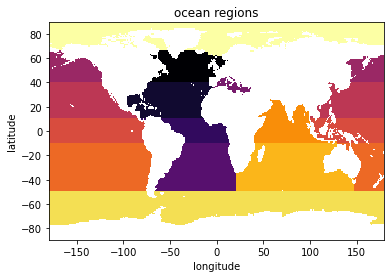

In [6]:
# regional maps
map=np.zeros((180,360))
for n in np.arange(1,Nb-2):
    bmask=get_bmask(n)
    map=map+bmask*n
map=np.where(map==0,np.nan,map)
x=np.arange(-180,180,1)+.5
y=np.arange(-90,90,1)+.5
plt.pcolormesh(x,y,map,cmap='inferno')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('ocean regions')
plt.savefig('ocean_regions.pdf')
plt.show()

In [7]:
# depth-resolved profile count for WOD OSD and CTD data
lev=[100,200,400,700,1000]
dsa=xr.open_dataset('cmip6_o2/WOD_sampl_pattern_osdctd_v1.nc')
D = dsa.prof_D.to_numpy()
#
N = dsa.prof_N.to_numpy().astype(float)
N[D<lev[0]]=np.nan
time=dsa.time
lat=dsa.lat
lon=dsa.lon
N100=xr.DataArray(data=N,name='prof_N100',dims=['time','lat','lon'],
                 coords={'time':time,'lat':lat,'lon':lon})
dsa['N100']=N100
#
N = dsa.prof_N.to_numpy().astype(float)
N[D<lev[1]]=np.nan
time=dsa.time
lat=dsa.lat
lon=dsa.lon
N200=xr.DataArray(data=N,name='prof_N200',dims=['time','lat','lon'],
                 coords={'time':time,'lat':lat,'lon':lon})
dsa['N200']=N200
#
N = dsa.prof_N.to_numpy().astype(float)
N[D<lev[3]]=np.nan
time=dsa.time
lat=dsa.lat
lon=dsa.lon
N700=xr.DataArray(data=N,name='prof_N700',dims=['time','lat','lon'],
                 coords={'time':time,'lat':lat,'lon':lon})
dsa['N700']=N700
#
N = dsa.prof_N.to_numpy().astype(float)
N[D<lev[2]]=np.nan
time=dsa.time
lat=dsa.lat
lon=dsa.lon
N400=xr.DataArray(data=N,name='prof_N400',dims=['time','lat','lon'],
                 coords={'time':time,'lat':lat,'lon':lon})
dsa['N400']=N400

In [8]:
N2y=dsa.N200.groupby('time.year').mean('time')
# aggregate pentadal data
year=N2y.year
yr=np.arange(1967,2013,1)
N2p=np.zeros((np.size(yr),180,360))
#
for n in range(np.size(yr)):
    ind=(year>=yr[n]-2)&(year<=yr[n]+2)
    #print(np.sum(ind))
    N2p[n,:,:]=N2y[ind,:,:].mean('year')

In [9]:
N7y=dsa.N700.groupby('time.year').mean('time')
# aggregate pentadal data
N7p=np.zeros((np.size(yr),180,360))
#
for n in range(np.size(yr)):
    ind=(year>=yr[n]-2)&(year<=yr[n]+2)
    N7p[n,:,:]=N7y[ind,:,:].mean('year')

In [10]:
N1y=dsa.N100.groupby('time.year').mean('time')
# aggregate pentadal data
N1p=np.zeros((np.size(yr),180,360))
#
for n in range(np.size(yr)):
    ind=(year>=yr[n]-2)&(year<=yr[n]+2)
    N1p[n,:,:]=N1y[ind,:,:].mean('year')

In [11]:
N4y=dsa.N400.groupby('time.year').mean('time')
# aggregate pentadal data
N4p=np.zeros((np.size(yr),180,360))
#
for n in range(np.size(yr)):
    ind=(year>=yr[n]-2)&(year<=yr[n]+2)
    N4p[n,:,:]=N4y[ind,:,:].mean('year')

In [12]:
da=xr.DataArray(data=N2p,name='prof_N200p',dims=['year','lat','lon'],
                 coords={'year':yr,'lat':lat,'lon':lon})
dsp=da.to_dataset()
#
da=xr.DataArray(data=N7p,name='prof_N700p',dims=['year','lat','lon'],
                 coords={'year':yr,'lat':lat,'lon':lon})
dsp['prof_N700p']=da
#
da=xr.DataArray(data=N1p,name='prof_N100p',dims=['year','lat','lon'],
                 coords={'year':yr,'lat':lat,'lon':lon})
dsp['prof_N100p']=da
da=xr.DataArray(data=N4p,name='prof_N400p',dims=['year','lat','lon'],
                 coords={'year':yr,'lat':lat,'lon':lon})
dsp['prof_N400p']=da

In [13]:
# data coverage maps
Nr=13
Ny=np.size(yr)
temp=np.ones((180,360))
#
# percent coverage is based on counting the grid cells with observation 
# in the running pentadal sense
#
coverage=np.zeros((4,Nr,Ny))
for m in range(Nr):
    bind=np.where(map==m+1,temp,0*temp)
    Nb0=np.sum(bind)
    for n in range(Ny):
        data=dsp['prof_N100p'].isel(year=n).to_numpy()
        coverage[0,m,n]=np.nansum(np.nansum(data*bind))/Nb0
        data=dsp['prof_N200p'].isel(year=n).to_numpy()
        coverage[1,m,n]=np.nansum(np.nansum(data*bind))/Nb0
        data=dsp['prof_N400p'].isel(year=n).to_numpy()
        coverage[2,m,n]=np.nansum(np.nansum(data*bind))/Nb0
        data=dsp['prof_N700p'].isel(year=n).to_numpy()
        coverage[3,m,n]=np.nansum(np.nansum(data*bind))/Nb0


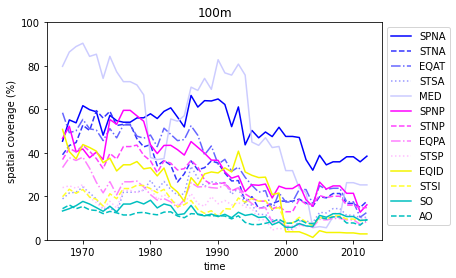

In [14]:
k=0 # 100m
basin0=basin[1:14]
sty=['-','--','-.',':','-','--']
for n in range(13):
    if n<=4:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('b',1-n/5),linestyle=sty[n])
    elif n<=8:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('m',1-(n-4)/5),linestyle=sty[n-5])
    elif n<=10:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('y',1-(n-8)/6),linestyle=sty[n-9])
    else:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color='c',linestyle=sty[n-11])

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('time')
plt.ylabel('spatial coverage (%)')
plt.title('100m')
plt.ylim(0,100)
plt.savefig('pentadal_datacoverage_100m.pdf',bbox_inches='tight')
plt.show()

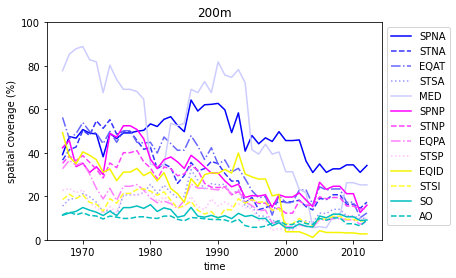

In [15]:
k=1 # 200m
basin0=basin[1:14]
for n in range(13):
    if n<=4:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('b',1-n/5),linestyle=sty[n])
    elif n<=8:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('m',1-(n-4)/5),linestyle=sty[n-5])
    elif n<=10:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('y',1-(n-8)/6),linestyle=sty[n-9])
    else:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color='c',linestyle=sty[n-11])

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('time')
plt.ylim(0,100)
plt.ylabel('spatial coverage (%)')
plt.title('200m')
plt.savefig('pentadal_datacoverage_200m.pdf',bbox_inches='tight')
plt.show()

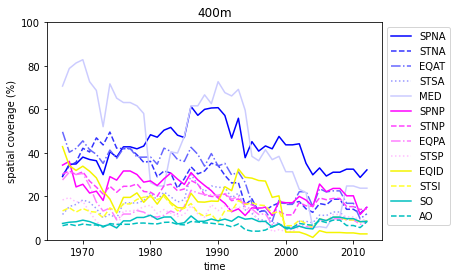

In [16]:
k=2 # 400m
basin0=basin[1:14]
for n in range(13):
    if n<=4:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('b',1-n/5),linestyle=sty[n])
    elif n<=8:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('m',1-(n-4)/5),linestyle=sty[n-5])
    elif n<=10:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('y',1-(n-8)/6),linestyle=sty[n-9])
    else:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color='c',linestyle=sty[n-11])

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('time')
plt.ylabel('spatial coverage (%)')
plt.title('400m')
plt.ylim(0,100)
plt.savefig('pentadal_datacoverage_400m.pdf',bbox_inches='tight')
plt.show()

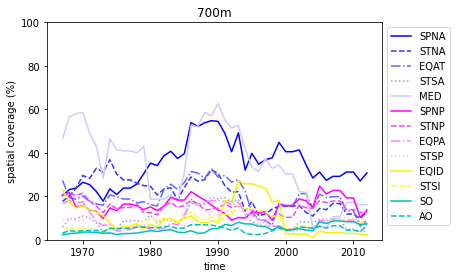

In [17]:
k=3 # 700m
basin0=basin[1:14]
for n in range(13):
    if n<=4:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('b',1-n/5),linestyle=sty[n])
    elif n<=8:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('m',1-(n-4)/5),linestyle=sty[n-5])
    elif n<=10:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color=lighten_color('y',1-(n-8)/6),linestyle=sty[n-9])
    else:
        plt.plot(yr,coverage[k,n,:]*1e2,label=basin0[n],
                 color='c',linestyle=sty[n-11])

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('time')
plt.ylabel('spatial coverage (%)')
plt.title('700m')
plt.ylim(0,100)
plt.savefig('pentadal_datacoverage_700m.pdf',bbox_inches='tight')
plt.show()

[[0.51059439 0.31560652 0.35756899 0.17702441 0.53458498 0.34677359
  0.27554542 0.1884855  0.1515988  0.24126503 0.1594314  0.12172072
  0.10683929]
 [0.4687672  0.30328941 0.34050818 0.16711653 0.51602986 0.30231801
  0.25577047 0.17822398 0.14269849 0.22807831 0.15009717 0.11147667
  0.09228442]
 [0.42276646 0.27090381 0.30014164 0.14797963 0.45992534 0.22297958
  0.20464079 0.14240428 0.11233669 0.17412369 0.12967405 0.08455225
  0.06962442]
 [0.34533419 0.21039743 0.19573801 0.0950299  0.34354414 0.15912793
  0.15111414 0.09950674 0.07474437 0.10292383 0.08476873 0.05004688
  0.05064059]]


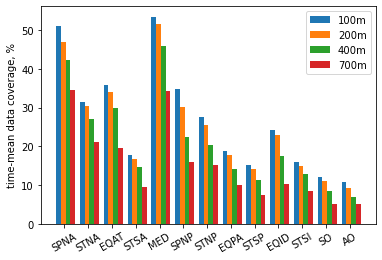

In [18]:
# average data coverage (pentadal)
covm=np.mean(coverage,axis=2)
x=np.arange(0,13,1)
print(covm)

#
plt.bar(x,covm[0,:]*100,.2,label='100m')
plt.bar(x+.2,covm[1,:]*100,.2,label='200m')
plt.bar(x+.4,covm[2,:]*100,.2,label='400m')
plt.bar(x+.6,covm[3,:]*100,.2,label='700m')

plt.xticks(x+.25,basin0,rotation=30)
plt.ylabel('time-mean data coverage, %')
plt.legend()
plt.savefig('datacover_bars.pdf',bbox_inches='tight')
plt.show()

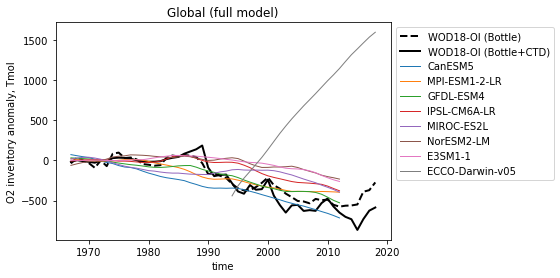

In [26]:
A=np.empty(Nm+3)
B=np.empty(Nm+3)
SEa=np.empty(Nm+3)
SEb=np.empty(Nm+3)
#
Nt=52
invdata = np.nan*np.zeros((Nt,Nm+3))
names=np.empty(Nm+3,dtype='U16')
#
# plot global time seires first
df=pd.read_csv('csvfiles/O2INV_WOD3.csv') # Winkler only
# factor for Tmol
fac=1e-12
time=df['year']
inv=df['GLOB']
inv=inv-np.mean(inv[:10])
plt.plot(time,fac*inv,'k--',linewidth=2,label='WOD18-OI (Bottle)')
A[0],B[0],SEa[0],SEb[0]=calc_trend(time,inv)
invdata[:,0]=time
names[0]='time'
invdata[:,1]=inv
names[1]='WOD18-Bottle-OI'
#
#
#df=pd.read_csv('csvfiles/O2INV_WOD2.csv') # Winkler and CTD
df=pd.read_csv('csvfiles/O2INV_WOD_v20220514-v2.csv')
# factor for Tmol
fac=1e-12
time=df['year']
inv=df['GLOB']
inv=inv-np.mean(inv[:10])
plt.plot(time,fac*inv,'k-',linewidth=2,label='WOD18-OI (Bottle+CTD)')
A[1],B[1],SEa[1],SEb[1]=calc_trend(time,inv)
invdata[:,2]=inv
names[2]='WOD18-Bottle+CTD-OI'
#

for n in range(Nm):
    df=pd.read_csv('csvfiles/O2INV_'+mods3[n]+'_ful.csv')
    time=df['year']
    inv=df['GLOB']
    inv=inv-np.mean(inv[:10])
    plt.plot(time,fac*inv,'-',linewidth=1,label=mods3[n])
    A[n+2],B[n+2],SEa[n+2],SEb[n+2]=calc_trend(time,inv)
    # - save numbers - 
    Nt=np.size(time)
    if (n==Nm-1):
        invdata[27:,n+3]=inv.to_numpy()
    else:
        invdata[:Nt,n+3]=inv.to_numpy()
    names[n+3]=mods3[n]
#
plt.xlabel('time')
plt.ylabel('O2 inventory anomaly, Tmol')
plt.title('Global (full model)')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('o2trend_timeseries-v2.pdf',bbox_inches='tight')
plt.show()
#

In [27]:
df=pd.DataFrame(data=invdata,columns=names)
df.to_csv('global_o2anom_mol.csv')

In [28]:
df

,time,WOD18-Bottle-OI,WOD18-Bottle+CTD,CanESM5,MPI-ESM1-2-LR,GFDL-ESM4,IPSL-CM6A-LR,MIROC-ES2L,NorESM2-LM,E3SM1-1,ECCO-Darwin-v05
0,1967.0,-3.773084e+13,-2.006144e+13,7.097903e+13,2.107532e+13,3.084309e+13,-8.835992e+12,1.650106e+13,-6.251609e+13,-1.637310e+11,NaN
1,1968.0,3.228174e+13,2.036375e+12,5.769121e+13,1.036289e+13,2.644690e+13,-3.176840e+12,2.930168e+13,-4.354956e+13,8.671429e+11,NaN
2,1969.0,-8.391745e+11,-9.261325e+12,4.533725e+13,2.429184e+11,2.164754e+13,4.254975e+12,3.698554e+13,-2.660677e+13,-6.380034e+11,NaN
3,1970.0,-3.398973e+13,-1.841267e+13,3.385762e+13,-5.708451e+12,1.691542e+13,8.145405e+12,3.860002e+13,-1.529151e+13,1.636661e+12,NaN
4,1971.0,-9.255323e+13,-2.937070e+13,1.419110e+13,-7.588403e+12,9.386345e+12,6.709818e+12,2.870187e+13,-1.007146e+13,4.122151e+12,NaN
5,1972.0,-2.051342e+12,-4.249446e+12,-8.506276e+12,-9.420313e+12,2.156025e+12,9.350853e+12,1.375832e+13,-6.204026e+12,1.150504e+12,NaN
6,1973.0,-7.188789e+13,-1.194357e+13,-2.565952e+13,-1.034594e+13,-8.017003e+12,5.932448e+12,-8.150495e+12,1.605262e+13,-1.349288e+12,NaN
7,1974.0,8.202104e+13,2.776171e+13,-3.975704e+13,-7.463371e+12,-2.188115e+13,-3.250983e+12,-3.124768e+13,4.102114e+13,-1.595055e+12,NaN
8,1975.0,9.623100e+13,3.327219e+13,-6.514061e+13,1.241062e+12,-3.361396e+13,-9.601843e+12,-5.199740e+13,5.108574e+13,-3.190395e+12,NaN
9,1976.0,2.851843e+13,3.022888e+13,-8.299276e+13,7.604289e+12,-4.388321e+13,-9.527841e+12,-7.245291e+13,5.607994e+13,-8.399869e+11,NaN
